モジュールの説明


In [ ]:
! pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.6 MB/s eta 0:00:00


In [ ]:
'''
#モジュールのためのライブラリ
import importlib
import sys
sys.path.append('/content/drive/MyDrive/graduation_research/notebook')

#モジュールのインポート
import listing
import cre_dist_matrix
import upgma

import numpy as np

importlib.reload(listing)
importlib.reload(cre_dist_matrix)
importlib.reload(upgma)
'''

"\n#モジュールのためのライブラリ\nimport importlib\nimport sys\nsys.path.append('/content/drive/MyDrive/graduation_research/notebook')\n\n#モジュールのインポート\nimport listing\nimport cre_dist_matrix\nimport upgma\n\nimport numpy as np\n\nimportlib.reload(listing)\nimportlib.reload(cre_dist_matrix)\nimportlib.reload(upgma)\n"

In [ ]:
from os import name
class Listing:

  def __init__(self, path):
    #path = '/content/drive/MyDrive/卒業研究/塩基配列サンプル/ex1_LSU_rRNA.txt'
    self.namelist = []
    self.ncllist = []
    file_line_num = 0


    with open(path) as f:
      for s_line in f:
        file_line_num += 1


    with open(path) as f:
      n = 0
      ncl = ''
      count = 0

      for s_line in f:
        count += 1
        if s_line[0] == '>':
          if n != 0:
            self.ncllist.append(ncl)
            ncl = ''
          self.namelist.append(s_line[:-1])
          n += 1
        else:
          ncl += ncl.join(s_line.splitlines())
          if file_line_num == count:
            self.ncllist.append(ncl)

  def return_list(self):
    return self.namelist, self.ncllist

In [ ]:
import numpy as np
import math
from decimal import Decimal

class DistMatrix:

  def __init__(self, ncl_list : list, method = 'k-mer', k=6):
    n = len(ncl_list)
    self.dist_matrix = np.zeros(n*n).reshape(n, n)

    if method == 'k-mer':
      for i in range(n):
        for j in range(i):
          kmer = Kmer(ncl_list[i], ncl_list[j], k)
          self.dist_matrix[i, j] = kmer.return_dist()

    elif method == 'kimura':
      for i in range(n):
        for j in range(i):
          kimura = Kimura(ncl_list[i], ncl_list[j])
          self.dist_matrix[i, j] = kimura.return_dist()

    elif method == 'newkimura':
      for i in range(n):
        for j in range(i):
          newkimura = NewKimura(ncl_list[i], ncl_list[j])
          self.dist_matrix[i, j] = newkimura.return_dist()

    else:
      print('ERROER')

  def return_dist_matrix(self):
    return self.dist_matrix





class Kmer:

  def __init__(self, a_seq: str, b_seq: str, k=6):
    self.dist = self.calculate(a_seq, b_seq, k)


  def calculate(self, a_seq, b_seq, k):
    a_len = len(a_seq)
    b_len = len(b_seq)
    mers_list = {}
    molecule = 0

    for mers in range(a_len - k + 1):
      if a_seq[mers:mers+k] in mers_list:
        mers_list[a_seq[mers:mers+k]][0] += 1
      else:
        mers_list[a_seq[mers:mers+k]] = [1,0]

    for mers in range(b_len - k + 1):
      if b_seq[mers:mers+k] in mers_list:
        mers_list[b_seq[mers:mers+k]][1] += 1
      else:
        mers_list[b_seq[mers:mers+k]] = [0, 1]

    for score in mers_list.values():
      molecule += self.min(score[0], score[1])

    #print(mers_list)
    return round(molecule / (self.min(a_len, b_len) - k + 1), 2)


  def min(self, a, b):
    if a >= b:
      return b
    else:
      return a

  def return_dist(self):
    return self.dist





class Kimura:

  def __init__(self, a_seq: str, b_seq: str):
    align = Align(a_seq, b_seq)
    align_a_seq, align_b_seq = align.return_align_seq()
    align_a_seq = list(align_a_seq)
    align_b_seq = list(align_b_seq)

    self.dist = self.calculate(align_a_seq, align_b_seq) #この後、align_a_seqとalign_b_seqのギャップサイトは削除されたまま


  def calculate(self, a_seq, b_seq):
    self.delete_gap(a_seq, b_seq)
    p, q = self.tran_match_num(a_seq, b_seq)
    p = str(p)
    q = str(q)

    a = Decimal('1.0') - 2 * Decimal(p) - Decimal(q)
    b = float(Decimal('1.0') - 2 * Decimal(q))
    b = str(math.sqrt(b))
    k = float(Decimal(a) * Decimal(b))
    k = -0.5 * math.log(k)

    return round(k, 2)


  def delete_gap(self, a_seq, b_seq): #参照渡しになっているので注意
    while '-' in a_seq:
      b_seq.pop(a_seq.index('-'))
      a_seq.remove('-')
    while '-' in b_seq:
      a_seq.pop(b_seq.index('-'))
      b_seq.remove('-')

    #return a_seq, b_seq


  def tran_match_num(self, a_seq, b_seq):
    t_num = 0
    s_num = 0
    all = len(a_seq)

    for n in range(all):
      c_type = self.tran_judge(a_seq[n], b_seq[n])
      if c_type == 'tran':
        t_num += 1
      elif c_type == 'sion':
        s_num += 1

    return round(float(t_num / all), 2), round(float(s_num / all), 2)


  def type_judge(self, nucl):
    if nucl == 'A' or  nucl == 'G' or nucl == 'a' or nucl == 'g':
      return 'purin'
    elif nucl == '-':
      return 'gap'
    else:
      return 'pirimijin'


  def tran_judge(self, a_nucl, b_nucl):
    if self.type_judge(a_nucl) == self.type_judge(b_nucl) and a_nucl != b_nucl:
      return 'tran'
    elif self.type_judge(a_nucl) != self.type_judge(b_nucl):
      return 'sion'
    else:
      return 'other'


  def return_dist(self):
    return self.dist





class NewKimura:

  def __init__(self, a_seq: str, b_seq: str):
    align = Align(a_seq, b_seq)
    align_a_seq, align_b_seq = align.return_align_seq()
    align_a_seq = list(align_a_seq)
    align_b_seq = list(align_b_seq)

    self.dist = self.calculate(align_a_seq, align_b_seq) #この後、align_a_seqとalign_b_seqのギャップサイトは削除されたまま


  def calculate(self, a_seq, b_seq):
    w = self.mixture_weight(a_seq, b_seq)
    self.delete_gap(a_seq, b_seq)
    s = self.match_num(a_seq, b_seq)
    p, q = self.tran_match_num(a_seq, b_seq)
    s = str(s)
    p = str(p)
    q = str(q)

    a = str(round(math.log(w), 2))
    a = Decimal('0.75') * Decimal(a)

    b = Decimal(s) - Decimal(p)
    c = float(Decimal(s) + Decimal(p) - Decimal(q))
    c = str(round(math.sqrt(c), 2))
    k = float(Decimal(b) * Decimal(c))
    k = str(round(math.log(k), 2))
    k = Decimal('0.5') * Decimal(k)

    k = Decimal(a) - Decimal(k)
    k = Decimal(str(w)) * Decimal(k)
    return round(float(k), 2)


  def mixture_weight(self, a_seq, b_seq): #the probability that nucleotides exist in two sequences compared
    num = 0
    all = len(a_seq)
    for n in range(all):
      if a_seq[n] != '-':
        num += 1
      if b_seq[n] != '-':
        num += 1
    return round(float(num / (2*all)), 2)


  def delete_gap(self, a_seq, b_seq): #参照渡しになっているので注意
    while '-' in a_seq:
      b_seq.pop(a_seq.index('-'))
      a_seq.remove('-')
    while '-' in b_seq:
      a_seq.pop(b_seq.index('-'))
      b_seq.remove('-')

    #return a_seq, b_seq



  def match_num(self, a_seq, b_seq):
    num = 0
    all = len(a_seq)
    for n in range(all):
      if a_seq[n] == b_seq[n]:
        num += 1
    return round(float(num / (all)), 2)


  def tran_match_num(self, a_seq, b_seq):
    t_num = 0
    s_num = 0
    all = len(a_seq)

    for n in range(all):
      c_type = self.tran_judge(a_seq[n], b_seq[n])
      if c_type == 'tran':
        t_num += 1
      elif c_type == 'sion':
        s_num += 1

    return round(float(t_num / all), 2), round(float(s_num / all), 2)


  def type_judge(self, nucl):
    if nucl == 'A' or  nucl == 'G' or nucl == 'a' or nucl == 'g':
      return 'purin'
    elif nucl == '-':
      return 'gap'
    else:
      return 'pirimijin'


  def tran_judge(self, a_nucl, b_nucl):
    if self.type_judge(a_nucl) == self.type_judge(b_nucl) and a_nucl != b_nucl:
      return 'tran'
    elif self.type_judge(a_nucl) != self.type_judge(b_nucl):
      return 'sion'
    else:
      return 'other'


  def return_dist(self):
    return self.dist





class Align:

  def __init__(self, a_seq, b_seq):
    self.n = len(a_seq)
    self.m = len(b_seq)

    score_table, arrow_table = self.base_scoring(a_seq, b_seq)
    score_table, arrow_table = self.main_scoring(score_table, arrow_table, a_seq, b_seq)
    self.align_a_seq, self.align_b_seq = self.rounting(score_table, arrow_table, a_seq, b_seq)


  def gap_penalty(self, k):
    return -1.5 * k


  def comparison_site(self, aij, biij):
    if aij == biij:
      return 1
    else:
      return 0


  def base_scoring(self, a_seq, b_seq): #アライメント計算時の表の１行目と一列目だけスコアを計算した状態
    score_table = np.zeros((self.n+1) * (self.m+1)).reshape(self.n+1, self.m+1)
    arrow_table = [['non']*(self.m+1) for i in range(self.n+1)]

    for i in range(self.m):
      arrow_table[0][i+1] = 'lateral'
    for i in range(self.n):
      arrow_table[i+1][0] = 'down'

    for j in range(self.m+1):
      score_table[0, j] = self.gap_penalty(j)
    for i in range(self.n+1):
      score_table[i, 0] = self.gap_penalty(i)

    return score_table,  arrow_table


  def main_scoring(self, score_table, arrow_table, a_seq, b_seq):
    for i in range(self.n):
      for j in range(self.m):
        candidate = []
        num = j
        conti_gap_count = 1

        #斜めの時のスコア
        candidate.append(score_table[i, j] + self.comparison_site(a_seq[i], b_seq[j]))
        #横の時のスコア
        while num > -1:
          if arrow_table[i+1][num] == 'lateral':
            conti_gap_count += 1
            num -= 1
          else:
            candidate.append(score_table[i+1, j + 1 - conti_gap_count] + self.gap_penalty(conti_gap_count))
            break

        #縦の時のスコア
        num = i
        conti_gap_count = 1
        while num > -1:
          if arrow_table[num][j+1] == 'down':
            conti_gap_count += 1
            num -= 1
          else:
            candidate.append(score_table[i + 1 - conti_gap_count, j+1] + self.gap_penalty(conti_gap_count))
            break

        #3択からどのルートが最適か調べる
        candidate = np.array(candidate)
        score = candidate.max()
        score_table[i+1, j+1] = score

        arrow_num = np.count_nonzero(candidate == score)

        if arrow_num == 1:
          if candidate.argmax() == 0:
            arrow_table[i+1][j+1] = 'diagonal'
          elif candidate.argmax() == 1:
            arrow_table[i+1][j+1] = 'lateral'
          else:
            arrow_table[i+1][j+1] = 'down'
        else:
          arrow = ''
          if candidate[0] == score:
            arrow += 'diagonal'
          if candidate[1] == score:
            arrow += 'lateral'
          if candidate[2] == score:
            arrow += 'down'
          arrow_table[i+1][j+1] = arrow

    return score_table, arrow_table


  def rounting(self, score_table, arrow_table, a_seq, b_seq):
    n = self.n
    m = self.m
    a_seq_alin = ''
    b_seq_alin = ''
    flag = True

    while flag:
      arrow = arrow_table[n][m]
      if arrow == 'diagonal':
        a_seq_alin = a_seq[n-1] + a_seq_alin
        b_seq_alin = b_seq[m-1] + b_seq_alin
        n = n - 1
        m = m - 1
      elif arrow == 'lateral':
        a_seq_alin = '-' + a_seq_alin
        b_seq_alin = b_seq[m-1] + b_seq_alin
        m = m - 1
      elif arrow == 'down':
        a_seq_alin = a_seq[n-1] + a_seq_alin
        b_seq_alin = '-' + b_seq_alin
        n = n - 1
      elif arrow == 'non':
        flag = False

      else: #今は時間がないので優先度を斜め,横,縦にするが、後で最適経路が複数ある場合は全て表示するようにする
        if 'diagonal' in arrow:
          a_seq_alin = a_seq[n-1] + a_seq_alin
          b_seq_alin = b_seq[m-1] + b_seq_alin
          n = n - 1
          m = m - 1
        elif 'lateral' in arrow:
          a_seq_alin = '-' + a_seq_alin
          b_seq_alin = b_seq[m-1] + b_seq_alin
          m = m - 1
        else:
          a_seq_alin = a_seq[n-1] + a_seq_alin
          b_seq_alin = '-' + b_seq_alin
          n = n - 1

    return a_seq_alin, b_seq_alin


  def return_align_seq(self):
    return self.align_a_seq, self.align_b_seq

In [ ]:
import numpy as np
import math

class UPGMA:

  def __init__(self, dist_matrix, name_list):
    self.newick = self.calculate(dist_matrix, name_list)


  def calculate(self, dist_matrix, name_list): #最小値が複数ある場合は先に出て来たペアがくっつくので改良の余地あり。ex)(A, B, C)みたいなのがない
    dist_matrix = dist_matrix.astype(np.float32)
    max_score = dist_matrix.max()
    num = len(name_list)
    for p in range(num):
      for q in range(p+1):
        dist_matrix[num-1-p, num-q-1] = max_score + 1

    while dist_matrix.shape[0] > 2:
      min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
      i = min_idx[0]
      j = min_idx[1]
      name_list[j] = '(' + name_list[j] + ', ' + name_list[i] + ')'
      name_list.pop(i)

      for p in range(dist_matrix.shape[0] - 1 - i):
        dist_matrix[i+p+1, j] = (dist_matrix[i+p+1, j] + dist_matrix[i+p+1, i]) / 2
      for p in range(i-j-1):
        dist_matrix[i-p-1, j] = (dist_matrix[i-p-1, j] + dist_matrix[i, i-p-1]) / 2
        #dist_matrix[j+1+p, j] = (dist_matrix[j+1+p, j] + dist_matrix[i, j+1+p]) / 2
      for p in range(j):
        dist_matrix[j, p] = (dist_matrix[i, p] + dist_matrix[j, p]) / 2

      #calを戻す、削除操作追加
      dist_matrix = np.delete(dist_matrix, i, 0)
      dist_matrix = np.delete(dist_matrix, i, 1)

    return name_list[0] + ', ' + name_list[1]


  def return_result(self):
    return self.newick

1385.978974469




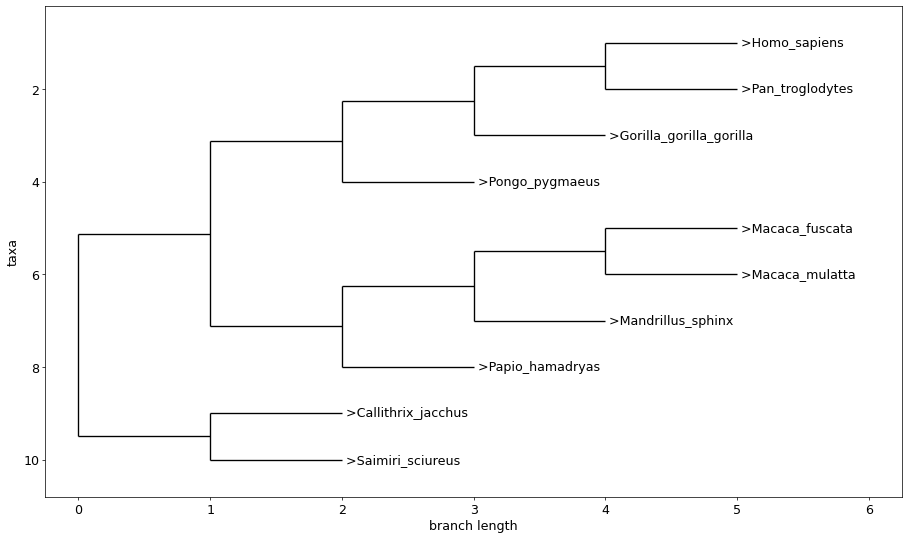

In [ ]:
from io import StringIO
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot

import time

start_time = time.perf_counter()

path = '/content/drive/MyDrive/graduation_research/data_sample/COX1_10type.txt'

li = Listing(path)
name_list, ncl_list = li.return_list()

k = 1
#dm = DistMatrix(ncl_list, 'k-mer', k)
dm = DistMatrix(ncl_list, 'kimura')
#dm = DistMatrix(ncl_list, 'newkimura')
dist_matrix = dm.return_dist_matrix()

up = UPGMA(dist_matrix, name_list)
treedata = up.return_result()

execution_time = time.perf_counter() - start_time
print(execution_time)
print('')
print('')

'''
tree: Tree = Phylo.read(file=StringIO(treedata), format="newick")
Phylo.draw_ascii(tree)
Phylo.draw(tree)
'''

handle = StringIO(treedata)  # parse the newick string
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=14)
fig = plt.figure(figsize=(17, 10), dpi=65)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)


0.000726376000017126




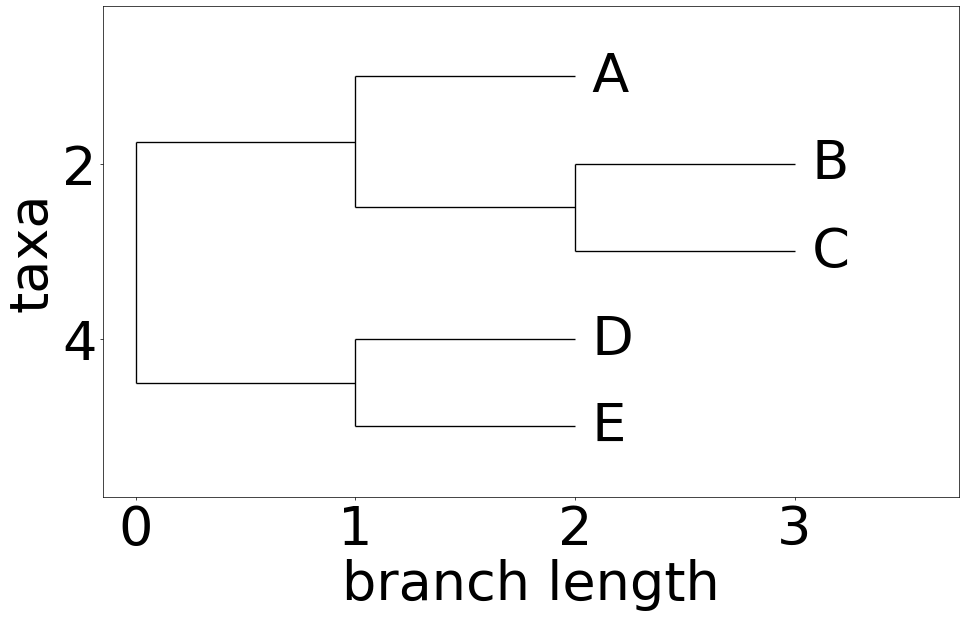

In [ ]:
taxa = ["A", "B", "C", "D", "E"]
distances = np.array(
    [
      [0, 0, 0, 0, 0],
      [0.3, 0, 0, 0, 0],
      [0.3, 0.2, 0, 0, 0],
      [0.5, 0.7, 0.9, 0, 0],
      [0.9, 0.7, 0.5, 0.4, 0],
    ]
 )
from io import StringIO
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot

import time

start_time = time.perf_counter()

up = UPGMA(distances, taxa)
treedata = up.return_result()

execution_time = time.perf_counter() - start_time
print(execution_time)
print('')
print('')

'''
tree: Tree = Phylo.read(file=StringIO(treedata), format="newick")
Phylo.draw_ascii(tree)
Phylo.draw(tree)
'''

handle = StringIO(treedata)  # parse the newick string
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=60)
fig = plt.figure(figsize=(17, 10), dpi=65)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

In [1]:
!python --version

Python 3.10.12
